<a href="https://colab.research.google.com/github/Rian-Jo/mujoco_playground/blob/main/mujoco_playground/experimental/learning/getup2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall Recovery Training Notebook

In [1]:
#@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 873.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.6/707.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [6]:
#@title Install MuJoCo Playground
!pip install playground

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.3 MB/s eta 0:00:00


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"

In [7]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [8]:
import functools
import json
from datetime import datetime

import jax
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp
from tqdm import tqdm

from mujoco_playground import locomotion, wrapper
from mujoco_playground.config import locomotion_params


# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:35<00:00]


Checking out commit 5e6af47a49bf8ae27581615b54045107b20ce584
Successfully downloaded mujoco_menagerie


In [9]:
env_name = "Go1Getup"
env_cfg = locomotion.get_default_config(env_name)
randomizer = locomotion.get_domain_randomizer(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [10]:
# env_cfg.reward_config.scales.dof_vel = 0.0

In [11]:
from pprint import pprint

pprint(ppo_params)

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.01
episode_length: 300
learning_rate: 0.0003
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 256
  - 128
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: privileged_state
normalize_observations: true
num_envs: 8192
num_evals: 5
num_minibatches: 32
num_timesteps: 50000000
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20



In [12]:
# Setup wandb logging.
USE_WANDB = False

if USE_WANDB:
  wandb.init(project="mjxrl", config=env_cfg)
  wandb.config.update({
      "env_name": env_name,
  })

In [13]:
SUFFIX = None
FINETUNE_PATH = None

# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
  exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
  FINETUNE_PATH = epath.Path(FINETUNE_PATH)
  latest_ckpts = list(FINETUNE_PATH.glob("*"))
  latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
  latest_ckpts.sort(key=lambda x: int(x.name))
  latest_ckpt = latest_ckpts[-1]
  restore_checkpoint_path = latest_ckpt
  print(f"Restoring from: {restore_checkpoint_path}")
else:
  restore_checkpoint_path = None

Experiment name: Go1Getup-20250227-061835


In [14]:
ckpt_path = epath.Path("checkpoints").resolve() / exp_name
ckpt_path.mkdir(parents=True, exist_ok=True)
print(f"{ckpt_path}")

with open(ckpt_path / "config.json", "w") as fp:
  json.dump(env_cfg.to_dict(), fp, indent=4)

/content/checkpoints/Go1Getup-20250227-061835


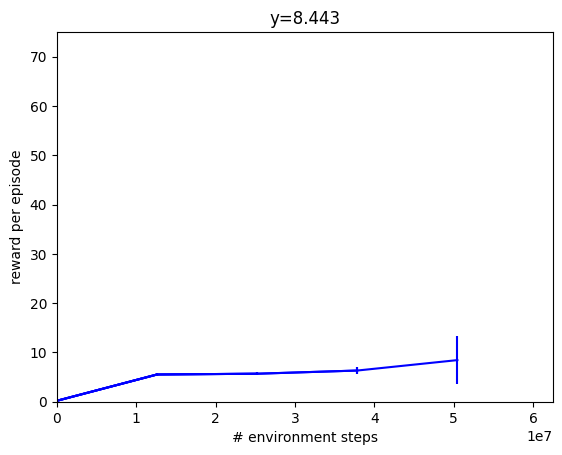

time to jit: 0:04:12.651227
time to train: 0:51:23.361988


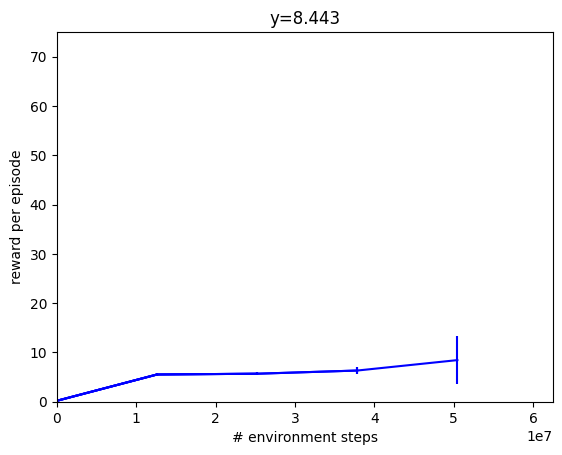

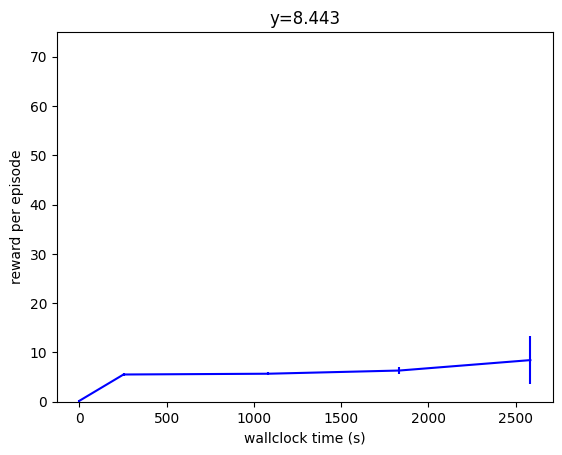

In [15]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def progress(num_steps, metrics):
  # Log to wandb.
  if USE_WANDB:
    wandb.log(metrics, step=num_steps)

  # Plot.
  clear_output(wait=True)
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params.num_timesteps * 1.25])
  plt.ylim([0, 75])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())


def policy_params_fn(current_step, make_policy, params):
  del make_policy  # Unused.
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f"{current_step}"
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)

training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
  ppo.train,
  **training_params,
  network_factory=functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  ),
  restore_checkpoint_path=restore_checkpoint_path,
  progress_fn=progress,
  wrap_env_fn=wrapper.wrap_for_brax_training,
  policy_params_fn=policy_params_fn,
  randomization_fn=randomizer,
)

env = locomotion.load(env_name, config=env_cfg)
eval_env = locomotion.load(env_name, config=env_cfg)
make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
if len(times) > 1:
  print(f"time to jit: {times[1] - times[0]}")
  print(f"time to train: {times[-1] - times[1]}")

# Make a final plot of reward and success vs WALLCLOCK time.
plt.figure()
plt.ylim([0, 75])
plt.xlabel("wallclock time (s)")
plt.ylabel("reward per episode")
plt.title(f"y={y_data[-1]:.3f}")
plt.errorbar(
    [(t - times[0]).total_seconds() for t in times[:-1]],
    y_data,
    yerr=y_dataerr,
    color="blue",
)
plt.show()

In [16]:
import pickle
# Save normalizer and policy params to the checkpoint dir.
normalizer_params, policy_params, value_params = params
with open(ckpt_path / "params.pkl", "wb") as f:
  data = {
    "normalizer_params": normalizer_params,
    "policy_params": policy_params,
    "value_params": value_params,
  }
  pickle.dump(data, f)

In [17]:
inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

env_cfg.drop_from_height_prob = 1.0
eval_env = locomotion.load(env_name, config=env_cfg)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [18]:
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
power = []
qfrc_constraint = []
qvels = []
power1 = []
power2 = []
for _ in tqdm(range(10)):
  rng, reset_rng = jax.random.split(rng)
  state = jit_reset(reset_rng)
  for i in range(env_cfg.episode_length // 2):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    actions.append(ctrl)
    state = jit_step(state, ctrl)
    rollout.append(state)
    rewards.append(
        {k[7:]: v for k, v in state.metrics.items() if k.startswith("reward/")}
    )
    torso_height.append(state.data.qpos[2])
    torques.append(state.data.actuator_force)
    qvel = state.data.qvel[6:]
    power.append(jp.sum(jp.abs(qvel * state.data.actuator_force)))
    qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
    qvels.append(jp.max(jp.abs(qvel)))
    frc = state.data.actuator_force
    qvel = state.data.qvel[6:]
    power1.append(jp.sum(frc * qvel))
    power2.append(jp.sum(jp.abs(frc * qvel)))

100%|██████████| 10/10 [02:19<00:00, 13.93s/it]


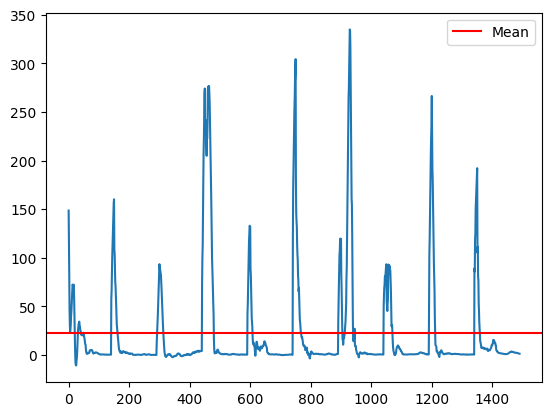

Min power: -10.788134574890137, Max power: 334.9940185546875


In [19]:
power = jp.array(power1)
# Plot smoothed power.
power = jp.convolve(power, jp.ones(10) / 10, mode='valid')
plt.plot(power)
# Plot mean as a horizontal line.
plt.axhline(y=jp.mean(jp.array(power)), color='r', linestyle='-', label='Mean')
plt.legend()
plt.show()
# Print min and max.
print(f"Min power: {jp.min(power)}, Max power: {jp.max(power)}")

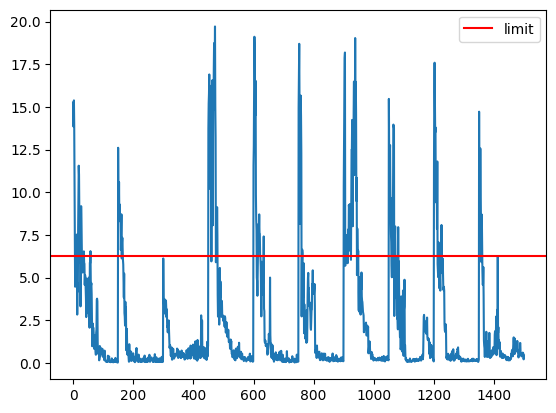

In [20]:
plt.plot(qvels)
plt.axhline(2 * jp.pi, color="red", label="limit")
plt.legend()
plt.show()


In [21]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj, camera="side", scene_option=scene_option, height=480, width=640
)
media.show_video(frames, fps=fps, loop=False)
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)

100%|██████████| 750/750 [00:02<00:00, 261.38it/s]
